In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from transformers import BertModel, BertTokenizer, DataCollatorWithPadding
!pip install livelossplot
from livelossplot import PlotLosses

#  ────────────────────────────────────────────────────────────────────
#   DATA IMPORT                                                        
#  ────────────────────────────────────────────────────────────────────
data = pd.read_parquet('/kaggle/input/resume-features-cleaned/resume-features.parquet', columns=['Category', 'cleaned_resumes'])

2024-06-17 20:17:55.412545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 20:17:55.412652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 20:17:55.681069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
#  ────────────────────────────────────────────────────────────────────
#   CPU VS GPU                                                         
#  ────────────────────────────────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))


Using cuda.


In [3]:
#  ────────────────────────────────────────────────────────────────────
#   DATASET AND DATALOADERS                                            
#  ────────────────────────────────────────────────────────────────────
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ResumeBertDataset(Dataset):
    def __init__(self, data, max_length, tokenizer=tokenizer, device=device):
        super().__init__()
        self.texts = data.iloc[:,1].values
        self.labels = torch.tensor(data.iloc[:,0])
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.device = device

    def __len__(self):
        return len(self.labels)

    def num_class(self):
        return len(self.labels.unique())

    def __getitem__(self, idx):
        resumes = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            resumes,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding=False,
            return_attention_mask=True,
            return_tensors='pt'
        ).to(self.device)

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

dataset = ResumeBertDataset(data, max_length=512)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
#  ────────────────────────────────────────────────────────────────────
#   MODEL DEFINITION                                                   
#  ────────────────────────────────────────────────────────────────────
class BertResumeClassifier(nn.Module):
    def __init__(self, n_classes: int, dropout: float = 0.01):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )['pooler_output']
        output = self.dropout(pooled_output)
        output = self.out(output)
        return output



In [6]:
def train_BERT(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler=None, visualize=None, save=None):
    """
    This function trains a PyTorch model using the given data loaders and hyperparameters.
    The function also supports visualization using liveloss or matplotlib.

    Parameters:
    - model: object: A PyTorch model object.
    - train_loader: DataLoader: A DataLoader object containing the training data.
    - val_loader: DataLoader: A DataLoader object containing the validation data.
    - criterion: object: A loss function object.
    - optimizer: object: An optimizer object.
    - epochs: int: The number of epochs to train the model.
    - scheduler: object: A learning rate scheduler object.
    - visualize: str: A string that determines the visualization method. Choose from [None, 'liveloss', 'matplotlib'].
    - save_path: str: A string containing the path to save the best model.

    Returns:
    Model performance metrics and visualization.
    """
    best_val_loss = float('inf')
    best_model_wts = None
    
    assert visualize in [None, 'liveloss', 'matplotlib'], "Invalid visualization method. Choose from [None, 'liveloss', 'matplotlib']."

    if visualize == 'liveloss':
        liveloss = PlotLosses()

    if visualize == 'matplotlib':
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training Phase
        logs = {}
        model.train()
        train_loss, train_corrects, train_total = 0.0, 0, 0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            data, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()

            outputs = model(input_ids=data, attention_mask=mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)
            train_total += data.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_corrects.double() / train_total

        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                data, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

                outputs = model(input_ids=data, attention_mask=mask) 
                loss = criterion(outputs, labels)

                val_loss += loss.item() * data.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += data.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_corrects.double() / val_total

        if visualize != 'liveloss':
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
            print(f"  Val Loss: {val_loss:.4f} |   Val Acc: {val_accuracy:.4f}")

        if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Save logs for visualization
        if visualize == 'liveloss':
            logs['log loss'] = train_loss
            logs['accuracy'] = train_accuracy.item()
            logs['val_log loss'] = val_loss
            logs['val_accuracy'] = val_accuracy.item()
            liveloss.update(logs)
            liveloss.send()
        elif visualize == 'matplotlib':
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy.cpu())  # Move to CPU
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.cpu())  # Move to CPU

        # Check if current model is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            print(f"👉 New best model with val loss: {val_loss:.4f}!")

        print("-" * 30)

    # Save best model
    if save and best_model_wts:
        torch.save(best_model_wts, save)
        print(f"Best model saved:")
        print(f"Val Loss: {best_val_loss:.4f} | Val Acc: {best_val_accuracy:.4f}")

    # Plot in matplotlib
    if visualize == 'matplotlib':
        plt.figure(figsize=(10, 5))

        # Plot training and validation losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # Plot training and validation accuracies
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    print("✅ Training complete!")

def test_BERT(model, test_loader, criterion):
    """
    This function tests a PyTorch model using the given data loader and loss function.

    Parameters:
    - model: object: A PyTorch model object.
    - test_loader: DataLoader: A DataLoader object containing the testing data.
    - criterion: object: A loss function object.

    Returns:
    Model performance metrics.
    """
    model.eval()
    test_loss, test_corrects, test_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=False):
            data, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

            outputs = model(data, mask)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_total += data.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = test_corrects.double() / test_total

    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    print("✅ Testing complete!")

    return test_loss, test_accuracy


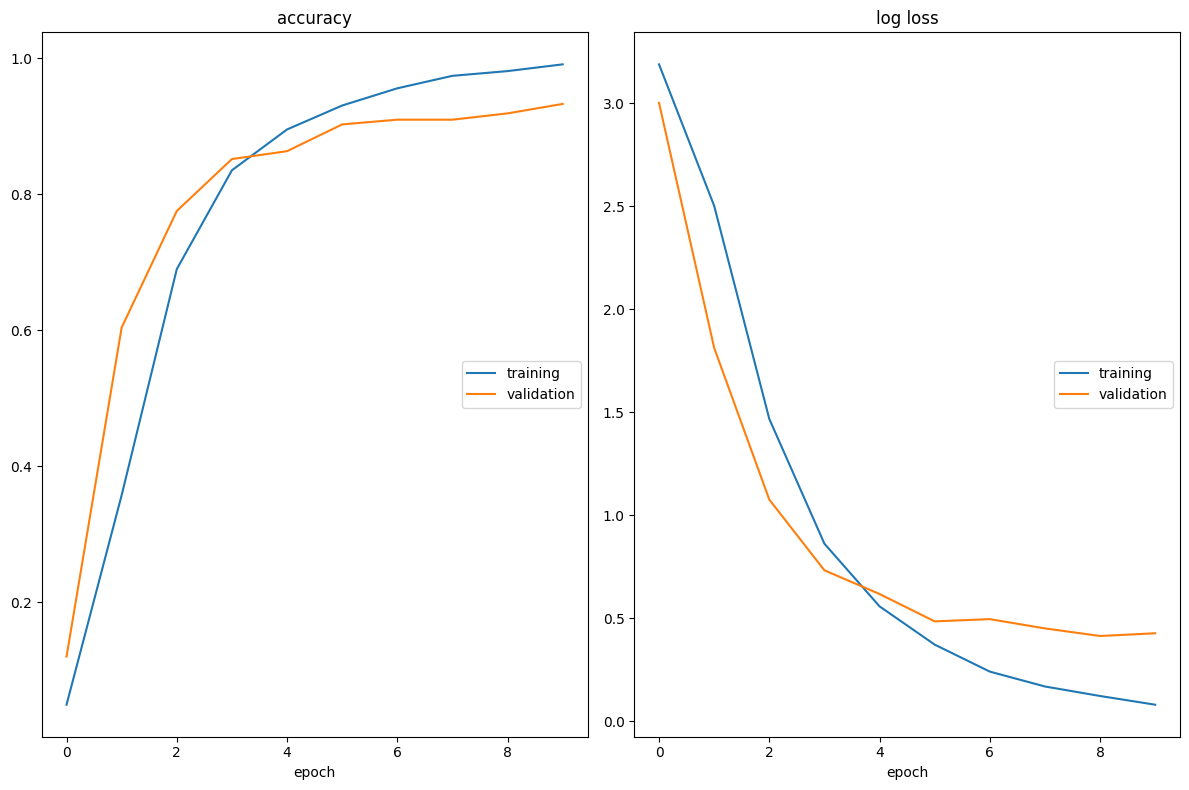

accuracy
	training         	 (min:    0.050, max:    0.991, cur:    0.991)
	validation       	 (min:    0.120, max:    0.933, cur:    0.933)
log loss
	training         	 (min:    0.081, max:    3.189, cur:    0.081)
	validation       	 (min:    0.414, max:    3.002, cur:    0.428)
------------------------------
Best model saved:
Val Loss: 0.4143 | Val Acc: 0.9190
✅ Training complete!


In [8]:
#  ────────────────────────────────────────────────────────────────────
#   HYPERPARAMETERS                                                    
#  ────────────────────────────────────────────────────────────────────
n_classes = dataset.num_class()
model = BertResumeClassifier(n_classes).to(device)
criterion = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, patience=2)
epochs = 10

train_BERT(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, 
           visualize='liveloss',
           save='bert-model.pth.gz')

In [9]:
test_BERT(model, test_loader, criterion)

Test Loss: 0.3743 | Test Acc: 0.9236
✅ Testing complete!


(0.37430223650126543, tensor(0.9236, device='cuda:0', dtype=torch.float64))